# Loading `cleaned` into memory using R's magic

In [1]:
cleaned <- read.csv("cleaned", header=0, row.names=1,sep="\t", skip=0)

## Renaming column and row descriptions appropriately

In [2]:
cleaned[,ncol(cleaned)] <- NULL

renameNumCols <- function(table, rowName) {
    result <- c()

    for (val in table[rowName,]) {
        result <- c(result, paste("X", val, sep=""))
    }
    
    colnames(table) <- result
    return(table)
}

renameNumRowsSelf <- function(table) {
    result <- c()
    for (rowName in rownames(table)) {
        result <- c(result, paste("X", rowName, sep="")) 
    }
    rownames(table) <- result
    return(table)
}

cleaned <- renameNumCols(cleaned, "IDs")

counter <- 0
for (val in rownames(cleaned)) {
    counter <- counter + 1
    if (val == "Affymetrix") {
        break
    }
}

metadata <- cleaned[c(1:counter-1),]
data <- cleaned[c((counter+1):nrow(cleaned)),]

data <- renameNumRowsSelf(data)

metadata <- t(metadata)
data <- data

In [3]:
design <- data.frame("ModalAllele" = as.numeric(metadata[,"ModalAllele"]))
rownames(design) <- rownames(metadata)
design

,ModalAllele
X189676HUEX1A11,872
X189694HUEX1A11,297
X189682HUEX1A11,593
X189598HUEX1A11,408
X189688HUEX1A11,717
X189604HUEX1A11,1035
X190217HUEX1A11,373
X189700HUEX1A11,118
X189706HUEX1A11,280
X190223HUEX1A11,993


### Example of fitting a single linear regression using built-in lm. I'm surprised at the amount of hackery involved to get this working -- clearly I'm doing something wrong.

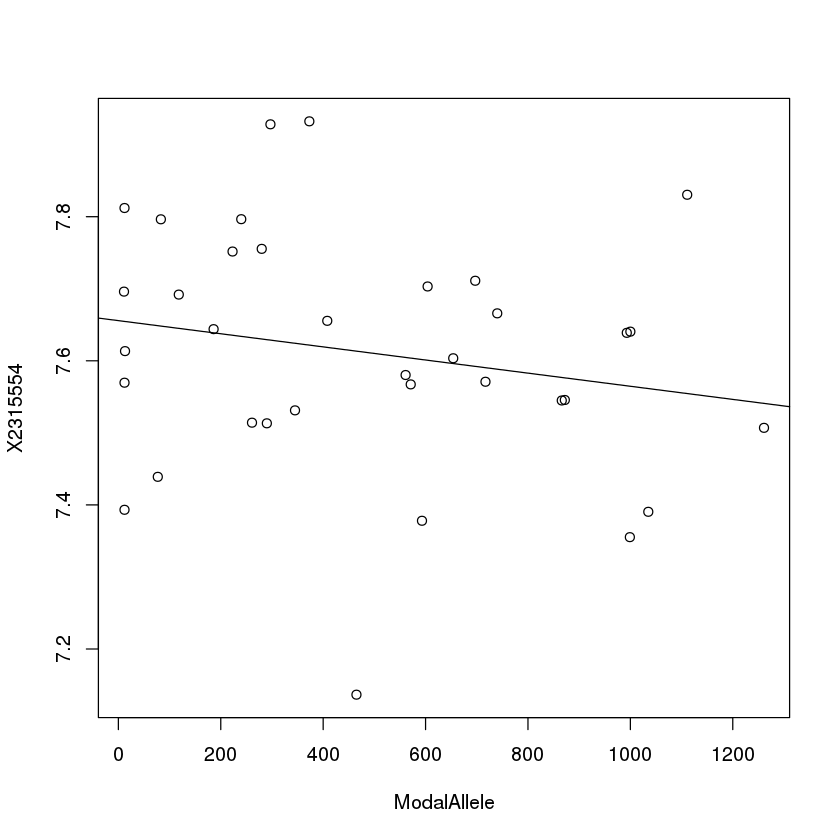

In [4]:
exampleData <- cleaned[c("ModalAllele", "2315554"), ]

rownames(exampleData) <- c("ModalAllele", "X2315554")
exampleData <- t(exampleData)
actualFrame <- data.frame("ModalAllele" = as.numeric(exampleData[,"ModalAllele"]), "X2315554" = as.numeric(exampleData[,"X2315554"]))
fit <- lm(X2315554 ~ ModalAllele, data=actualFrame)
plot(actualFrame)
abline(fit)

## The real deal -- fitting model with limma

In [5]:
typeof(data[1, 1])
data2 <- as.matrix(data)

[1] "integer"

In [6]:
data3 <- as.numeric(data2)

In [7]:
data4 <- matrix(data3, ncol=ncol(data), nrow=nrow(data))

In [8]:
rownames(data4) <- rownames(data2)
colnames(data4) <- colnames(data2)

In [9]:
library(limma)
require(Biobase)

#eset <- new("ExpressionSet", exprs=data)

# no idea how to fix this...
result <- lmFit(data4, design)

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit

Welcome to Bioconductor

    Vignettes contain introductory ma

In [10]:
resultEbayes <- eBayes(result)
all <- topTable(resultEbayes, n=Inf)
topTable(resultEbayes, n=10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
X2383894,0.01280524,9.345057,9.036496,1.750250e-11,1.281278e-09,14.27286
X2787958,0.01450216,10.686969,8.914528,2.571264e-11,1.281278e-09,13.88390
X3657253,0.01506176,11.113207,8.903674,2.661016e-11,1.281278e-09,13.84921
X2896545,0.01487191,10.996924,8.889329,2.784526e-11,1.281278e-09,13.80334
X2435005,0.01504998,11.140480,8.860423,3.051300e-11,1.281278e-09,13.71084
X3759006,0.01491451,11.040790,8.859556,3.059696e-11,1.281278e-09,13.70806
X2383884,0.01429626,10.574257,8.857355,3.081091e-11,1.281278e-09,13.70102
X2778856,0.01288273,9.483632,8.849761,3.156107e-11,1.281278e-09,13.67670
X3621029,0.01276155,9.392670,8.836839,3.288019e-11,1.281278e-09,13.63531
X2411173,0.01448626,10.727900,8.831224,3.347069e-11,1.281278e-09,13.61732


## Write genes sorted by relevance for further work in python.

In [11]:
write.table(all, file = "cleanedLimma")